# 8-pNEUMA trajectory dataset processing

In this example, the pNEUMA trajectory at Athens will be processed and visualized.   
Note that the sample data has been reshaped to a neat form. The origin version of pNEUMA dataset can be download at this [website](https://open-traffic.epfl.ch/)

To run this example, you may have to install `osmnx` :  

> conda install -c conda-forge osmnx

In [1]:
import transbigdata as tbd
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
print(tbd.__version__)

0.3.8


## Read the data

### The trajectory data

In [2]:
# Read data
data = pd.read_csv('data/pNEUMA_tbd_sample.csv')

# Transform the timestamp into Datetime
data['time'] = pd.to_datetime(data['time'], unit='s')

# print the file size
print(data.info())

data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581244 entries, 0 to 581243
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   track_id  581244 non-null  int64         
 1   lon       581244 non-null  float64       
 2   lat       581244 non-null  float64       
 3   speed     581244 non-null  float64       
 4   time      581244 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 22.2 MB
None


,track_id,lon,lat,speed,time
0,128,23.730362,37.990046,12.5845,1970-01-01 00:00:00.000
1,128,23.730364,37.990045,12.4935,1970-01-01 00:00:00.040
2,128,23.730366,37.990045,12.3965,1970-01-01 00:00:00.080
3,128,23.730367,37.990045,12.2949,1970-01-01 00:00:00.120
4,128,23.730369,37.990044,12.1910,1970-01-01 00:00:00.160


### OSM Map Data

You can load the map data directly from the `data` folder or download it using the [OSMNX package](https://osmnx.readthedocs.io/en/stable/)

In [3]:
# Load data from OSMNX

# OSM Graph
bounds = [23.723577, 37.975462, 23.738471, 37.993053]
north, south, east, west = bounds[3], bounds[1], bounds[2], bounds[0]
G = ox.graph_from_bbox(north, south, east, west, network_type='drive')

# get the nodes and edges
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)
print('number of nodes:{}, numer of edges: {}'.format(len(nodes), len(edges)))

# save/load graph as a graphml file
# filepath = "data/pNEUMA_network.graphml"
# ox.save_graphml(G, filepath)

number of nodes:471, numer of edges: 846


If you are not using OSMNX, you can run the code below

In [4]:
# Load the prepared OSM data
import osmnx as ox
filepath = "data/pNEUMA_network.graphml"
G = ox.load_graphml(filepath)

# get the nodes and edges
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

### Basemap Visualization

Combined with the Graph from OSM

TransBigData also provide basemap loading in matplotlib. Before using this method, you need to set your mapboxtoken and the storage location for the basemap, see: [this link](https://transbigdata.readthedocs.io/en/latest/plot_map.html). `tbd.plot_map` to add basemap and `tbd.plotscale` to add scale and compass.

In [4]:
bounds = [23.723577, 37.975462, 23.738471, 37.993053]

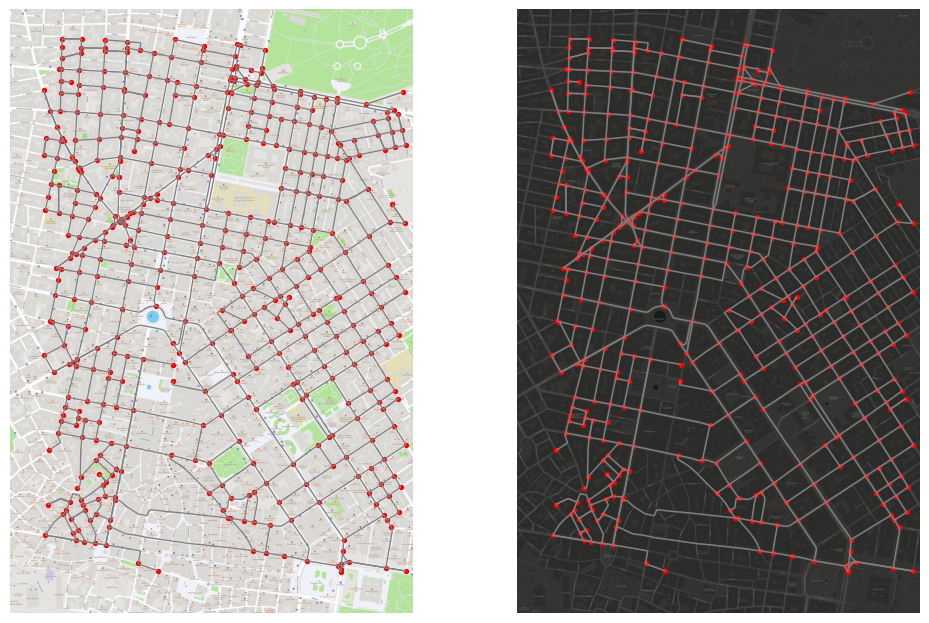

In [8]:
# Map visualization via tbd.plot_map
fig = plt.figure(1, (12, 8), dpi=100)
ax = plt.subplot(121)
plt.sca(ax)
tbd.plot_map(plt, bounds, zoom=18, style=1) # the map
edges.plot(ax=ax, lw=1, color='grey') # edges
nodes.plot(ax=ax, markersize = 8, color='red') # nodes
plt.axis('off');

ax = plt.subplot(122)
plt.sca(ax)
tbd.plot_map(plt, bounds, zoom=18, style=5) # the map
edges.plot(ax=ax, lw=1, color='grey') # edges
nodes.plot(ax=ax, markersize = 8, color='red') # nodes
plt.axis('off');

## Data Cleaning

### Data Sparisify

The sampling interval in this dataset is $0.04$ second, which is amazing.  
However, some marcoscopic studies do not need such a high-frequency for better processing efficiency. In this case, the data can be sparsified using `tbd.traj_sparsify`.

In [6]:
# let's check the origin data again
print('The number of rows of the origin data: \n')
data.info()

The number of rows of the origin data: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581244 entries, 0 to 581243
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   track_id  581244 non-null  int64         
 1   lon       581244 non-null  float64       
 2   lat       581244 non-null  float64       
 3   speed     581244 non-null  float64       
 4   time      581244 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 22.2 MB


In [7]:
# change the sampling frequency to 0.4 second
data_sparsify = tbd.traj_sparsify(data, 
                                  col=['track_id', 'time', 'lon', 'lat'], 
                                  timegap=0.4, 
                                  method='subsample') # do not using interpolate method
print('The number of rows of the de-sampled data: \n')
data_sparsify.info()

# check-points (please do not activate the following code)
# data_sparsify.to_csv('data/data_sparsify.csv', index=None) 

The number of rows of the de-sampled data: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23293 entries, 0 to 581229
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   track_id  23293 non-null  int64         
 1   lon       23293 non-null  float64       
 2   lat       23293 non-null  float64       
 3   speed     23293 non-null  float64       
 4   time      23293 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 1.1 MB


### Data compress

Remove the stopped points except for the first and the last point for each vehicle.

**check-points**

In [8]:
import transbigdata as tbd
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
import os

path = 'data/data_sparsify.csv'  
if os.path.exists(path):
    data_sparsify = pd.read_csv('data/data_sparsify.csv')
    print('number of rows:', len(data_sparsify))
else:
    print('no such a file, please check again')

number of rows: 23293


In [19]:
# using TBD to clean the stopping points
data_sparsify_clean = tbd.clean_same(data_sparsify, col=['track_id', 'time', 'lon', 'lat'])
print('The number of rows of the compressed data:', len(data_sparsify_clean))

data_sparsify_clean.info()
data_sparsify_clean.head()

The number of rows of the compressed data: 10674
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10674 entries, 0 to 23292
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   track_id  10674 non-null  int64  
 1   lon       10674 non-null  float64
 2   lat       10674 non-null  float64
 3   speed     10674 non-null  float64
 4   time      10674 non-null  object 
dtypes: float64(3), int64(1), object(1)
memory usage: 500.3+ KB


,track_id,lon,lat,speed,time
0,128,23.730362,37.990046,12.5845,1970-01-01 00:00:00.000
1,128,23.730399,37.990040,10.6835,1970-01-01 00:00:01.000
2,128,23.730429,37.990036,7.8580,1970-01-01 00:00:02.000
3,128,23.730443,37.990033,1.2661,1970-01-01 00:00:03.000
71,128,23.730443,37.990033,0.0027,1970-01-01 00:01:11.000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10674 entries, 0 to 23292
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   track_id  10674 non-null  int64   
 1   lon       10674 non-null  float64 
 2   lat       10674 non-null  float64 
 3   speed     10674 non-null  float64 
 4   time      10674 non-null  object  
 5   geometry  10674 non-null  geometry
 6   dist      10674 non-null  float64 
 7   index     10674 non-null  int64   
dtypes: float64(4), geometry(1), int64(2), object(1)
memory usage: 750.5+ KB


## Data Visualization

A `GeoDataFrame` format is required for visualization

In [10]:
gdf_data = gpd.GeoDataFrame(data_sparsify_clean, 
                            geometry=gpd.points_from_xy(data_sparsify_clean['lon'], 
                                                        data_sparsify_clean['lat']), 
                            crs=4326)
gdf_data.head()

,track_id,lon,lat,speed,time,geometry
0,128,23.730362,37.990046,12.5845,1970-01-01 00:00:00.000,POINT (23.73036 37.99005)
1,128,23.730399,37.990040,10.6835,1970-01-01 00:00:01.000,POINT (23.73040 37.99004)
2,128,23.730429,37.990036,7.8580,1970-01-01 00:00:02.000,POINT (23.73043 37.99004)
3,128,23.730443,37.990033,1.2661,1970-01-01 00:00:03.000,POINT (23.73044 37.99003)
71,128,23.730443,37.990033,0.0027,1970-01-01 00:01:11.000,POINT (23.73044 37.99003)


### Visualization of all vehicles

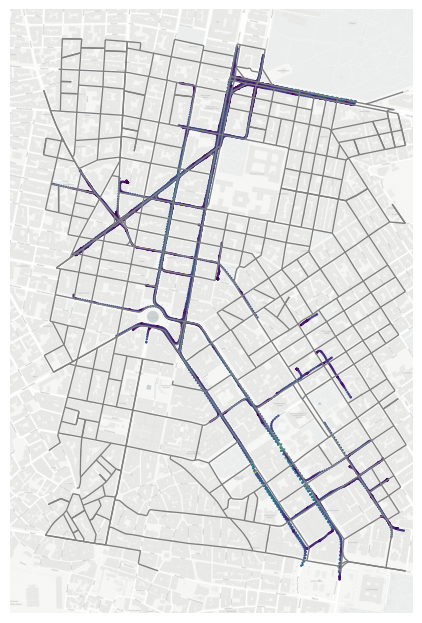

In [11]:
fig = plt.figure(1, (6, 8), dpi=100)

ax = plt.subplot(111)
plt.sca(ax)

# map
tbd.plot_map(plt, bounds, zoom=18, style=4) # the map
edges.plot(ax=ax, lw=1, color='grey') # edges
# nodes.plot(ax=ax, markersize = 6, color='red') # nodes

# trajectory
gdf_data.plot(column='speed', ax=ax, markersize=0.5)

plt.axis('off');

### Visualization of a single vehicle

veh_list:  [2138, 3290, 3197, 1442, 4408, 1767, 5002, 5022, 2140, 347, 2584, 4750, 4542, 2431, 4905, 4997, 1329, 4263, 1215, 3400]


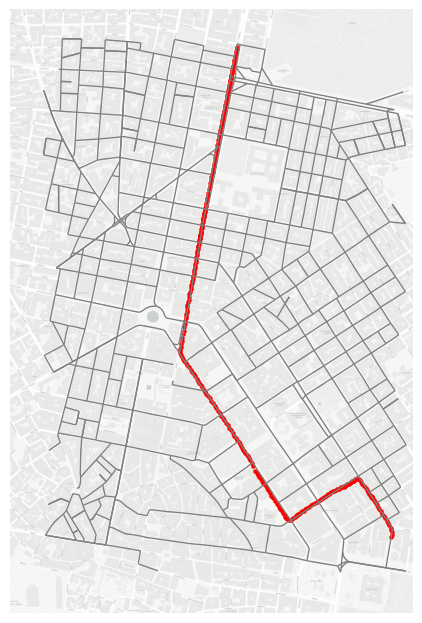

In [13]:
fig = plt.figure(1, (6, 8), dpi=100)

ax = plt.subplot(111)
plt.sca(ax)

# map
tbd.plot_map(plt, bounds, zoom=18, style=4) # the map
edges.plot(ax=ax, lw=1, color='grey') # edges
# nodes.plot(ax=ax, markersize = 6, color='red') # nodes

# trajectory

# get the vehicle list of top-ranked number of points
gdf_count = gdf_data.groupby('track_id')['lon'].count().rename('count').sort_values(ascending=False).reset_index()
veh_list = list(gdf_count.iloc[:20]['track_id'])
print('veh_list: ', veh_list)

# plot the first vehicle
gdf_data[gdf_data['track_id']==veh_list[1]].plot(ax=ax, markersize=5, color='red')  # the first vehicle
plt.axis('off'); 

### Compared with the shortes path
Users can compared the path with the shortes path.

In [14]:
# Finding the nearest nodes for each points (this cell can be executed only once)
gdf_data_2 = tbd.ckdnearest_point(gdf_data, nodes)
gdf_data_2.head()

,track_id,lon,lat,speed,time,geometry_x,dist,index,y,x,street_count,highway,geometry_y
0,128,23.730362,37.990046,12.5845,1970-01-01 00:00:00.000,POINT (23.73036 37.99005),0.000440,48,37.989959,23.730794,4,NaN,POINT (23.73079 37.98996)
1,128,23.730399,37.990040,10.6835,1970-01-01 00:00:01.000,POINT (23.73040 37.99004),0.000403,48,37.989959,23.730794,4,NaN,POINT (23.73079 37.98996)
2,128,23.730429,37.990036,7.8580,1970-01-01 00:00:02.000,POINT (23.73043 37.99004),0.000373,48,37.989959,23.730794,4,NaN,POINT (23.73079 37.98996)
3,128,23.730443,37.990033,1.2661,1970-01-01 00:00:03.000,POINT (23.73044 37.99003),0.000358,48,37.989959,23.730794,4,NaN,POINT (23.73079 37.98996)
4,128,23.730443,37.990033,0.0027,1970-01-01 00:01:11.000,POINT (23.73044 37.99003),0.000358,48,37.989959,23.730794,4,NaN,POINT (23.73079 37.98996)


In [15]:
# extract the o/d node for the first vehicle 
o_index = gdf_data_2[gdf_data_2['track_id']==3290].iloc[0]['index']
d_index = gdf_data_2[gdf_data_2['track_id']==3290].iloc[-1]['index'] 

o_node_id = list(nodes[nodes['index']==o_index].index)[0] 
d_node_id = list(nodes[nodes['index']==d_index].index)[0] 

print(o_node_id, d_node_id) 

# gdf_data_2.head() 

97788216 6220792260


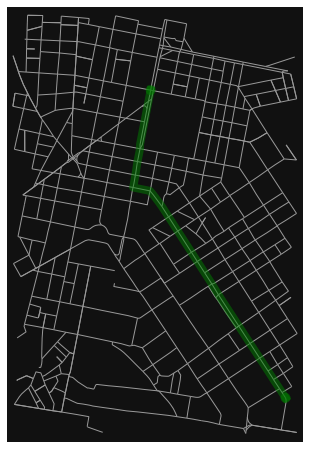

In [16]:
# the shortest path (optional)
# ax = plt.subplot(122)
# plt.sca(ax)
route = ox.shortest_path(G, o_node_id, d_node_id, weight="length")
plt, ax = ox.plot_graph_route(G, route, route_color="green", route_linewidth=8, node_size=0)